<a href="https://colab.research.google.com/github/nasbeck/nasbeck.github.io/blob/main/02_Upgraded_Thesis_First_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1 – Project scaffold
from google.colab import drive
from pathlib import Path

drive.mount('/content/gdrive', force_remount=True)

# Project root to “Thesis Data”
from pathlib import Path

ROOT          = Path('/content/gdrive/MyDrive/Thesis Data')
RAW_DIR       = ROOT / 'data_raw'
PROCESSED_DIR = ROOT / 'data_processed'
FIG_DIR       = ROOT / 'fig'
MODEL_MD      = ROOT / 'model_selection.md'
JUST_MD       = ROOT / 'justifications.md'

for d in (RAW_DIR, PROCESSED_DIR, FIG_DIR):
    d.mkdir(exist_ok=True, parents=True)

for md in (MODEL_MD, JUST_MD):
    if not md.exists():
        md.write_text(f"# {md.stem.replace('_',' ').title()}\n\n")

Mounted at /content/gdrive


In [ ]:
# Cell 2 – Ingest & log raw data
from pathlib import Path
import datetime

ROOT     = Path('/content/gdrive/MyDrive/Thesis Data')
RAW_DIR  = ROOT / 'data_raw'
MODEL_MD = ROOT / 'model_selection.md'

pdfs       = sorted(RAW_DIR.rglob('*.pdf'))
source_cnt = {}
for p in pdfs:
    source_cnt[p.parent.name] = source_cnt.get(p.parent.name, 0) + 1

now = datetime.datetime.now().isoformat()
with open(MODEL_MD, 'a') as f:
    f.write(f"## Data ingestion @ {now}\n")
    f.write(f"- Total PDFs: {len(pdfs)}\n")
    for src, cnt in source_cnt.items():
        f.write(f"- {src}: {cnt}\n")
    f.write("\n")

In [ ]:
!mv finsenticnet_esg_terms.csv "/content/gdrive/MyDrive/Thesis Data/data_raw/"
!echo "📁 data_raw now contains:"
!ls "/content/gdrive/MyDrive/Thesis Data/data_raw/"

📁 data_raw now contains:
finsenticnet_esg_terms.csv  LoughranMcDonald_MasterDictionary.csv


In [ ]:
# Cell 3a: Lexicon Seed Creation (precise file matching)
# -------------------------------------------------------
!pip install --quiet pandas openpyxl pyyaml

import pandas as pd
import yaml
from pathlib import Path

RAW_DIR = Path('/content')

# 1) Find the L-M file
lm_path = next(
    (p for p in RAW_DIR.iterdir()
     if 'loughran' in p.name.lower() and p.suffix.lower() in ('.xlsx','.csv')),
    None
)
if not lm_path:
    raise FileNotFoundError("L-M file not found in /content; upload and rerun.")

# 2) Load L-M DataFrame
if lm_path.suffix.lower()=='.xlsx':
    lm_df = pd.read_excel(lm_path, sheet_name='LoughranMcDonald_MasterDictionary')
else:
    lm_df = pd.read_csv(lm_path)

# 3) Identify word & flag columns
word_col = next(c for c in lm_df.columns if c.lower()=='word')
flag_cols = [c for c in lm_df.columns if c.lower() in
             ('uncertainty','negative','litigation','litigious','constraining')]
if not flag_cols:
    raise KeyError(f"No sentiment flags in {lm_path.name}. Expected columns like {flag_cols}")

# 4) Collect L-M keywords
lm_keywords = set(
    lm_df.loc[lm_df[flag_cols].any(axis=1), word_col]
         .str.lower()
         .tolist()
)
print(f"🔑 Loaded {len(lm_keywords)} L-M terms")

# 5) Find the ESG‐specific FinSenticNet file
fsn_path = next(
    (p for p in RAW_DIR.iterdir()
     if 'finsentic' in p.name.lower() and 'esg' in p.name.lower() and p.suffix.lower()=='.csv'),
    None
)
if not fsn_path:
    raise FileNotFoundError("ESG FinSenticNet CSV not found; upload 'finsenticnet_esg_terms.csv' and rerun.")

# 6) Load ESG CSV
fsn_df = pd.read_csv(fsn_path)
term_col = next(c for c in fsn_df.columns if 'term' in c.lower())
esg_headers = ['environmental','social','climate','scope 3','sustainability']
esg_keywords = set(esg_headers) | set(fsn_df[term_col].str.lower())
print(f"🔑 Loaded {len(esg_keywords)} ESG terms")

# 7) Write seed YAML
seed_keywords = {'risk': sorted(lm_keywords), 'esg': sorted(esg_keywords)}
with open('keywords.yml','w') as f:
    yaml.dump(seed_keywords, f, sort_keys=False)

print("✅ keywords.yml created with your seed lists")

🔑 Loaded 3506 L-M terms
🔑 Loaded 13 ESG terms
✅ keywords.yml created with your seed lists


In [ ]:
# Cell 4: Improved Preprocessing with PyPDF2 + Decryption Fallback
!pip install --quiet pycryptodome PyPDF2 gensim nltk

import pickle
from pathlib import Path
from PyPDF2 import PdfReader
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Setup lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Your two report folders
PDF_DIRS = [
    Path('/content/drive/MyDrive/Thesis Data/ING'),
    Path('/content/drive/MyDrive/Thesis Data/Klarna')
]

corpus_texts = []
for folder in PDF_DIRS:
    if not folder.exists():
        print(f"⚠️ Folder not found: {folder}")
        continue
    pdfs = list(folder.glob('*.pdf'))
    print(f"🔍 Found {len(pdfs)} PDFs in {folder.name}")
    for pdf_path in pdfs:
        try:
            reader = PdfReader(str(pdf_path))
            # Decrypt if needed (empty password)
            if reader.is_encrypted:
                try:
                    reader.decrypt('')
                except Exception:
                    print(f"⚠️ Could not decrypt {pdf_path.name}, skipping")
                    continue
            text = ""
            for page in reader.pages:
                text += (page.extract_text() or "") + " "
        except Exception as e:
            print(f"⚠️ Error reading {pdf_path.name}: {e}")
            continue

        # Tokenize + lemmatize
        tokens = simple_preprocess(text, deacc=True)
        lemmed = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
        corpus_texts.append(lemmed)

if not corpus_texts:
    raise FileNotFoundError("No PDFs processed—check your PDF_DIRS paths.")

print(f"🔄 Processed {len(corpus_texts)} documents total")

# Build bigrams & trigrams
phrases = Phrases(corpus_texts, min_count=5, threshold=10)
bigram = Phraser(phrases)
trigram = Phraser(Phrases(bigram[corpus_texts]))
corpus_phrased = [trigram[bigram[doc]] for doc in corpus_texts]

# Save tokenized corpus
with open('/content/tokenized_corpus.pkl', 'wb') as f:
    pickle.dump(corpus_phrased, f)
print(f"✅ Saved tokenized_corpus.pkl with {len(corpus_phrased)} docs")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mounted at /content/drive
🔍 Found 38 PDFs in ING
⚠️ Error reading 2016 Annual Report ING Groep N.V..pdf: PyCryptodome is required for AES algorithm
⚠️ Error reading 2015 Annual Report ING Groep NV.pdf: PyCryptodome is required for AES algorithm
⚠️ Error reading 2017-Annual Report Groep N.V..pdf: PyCryptodome is required for AES algorithm
⚠️ Error reading 2017 Annual Report ING Bank.pdf: PyCryptodome is required for AES algorithm
⚠️ Error reading 2014- ING_Group_Annual_Report_2014.pdf: PyCryptodome is required for AES algorithm
⚠️ Error reading 2013- ING_Groep_N.V._Annual_Report_2013.pdf: PyCryptodome is required for AES algorithm
⚠️ Error reading 2012 - Annual_Report_ING_Groep_N.V..pdf: PyCryptodome is required for AES algorithm
⚠️ Error reading 2011 - Annual_Report_ING_Group.pdf: PyCryptodome is required for AES algorithm
⚠️ Error reading 2019-Annual-Report-ING-Group-NV.pdf: PyCryptodome is required for AES algorithm
⚠️ Error reading ING-Group-Annual-Report-2020.pdf: PyCryptodome is r

In [ ]:
# Cell 3b: FastText Expansion
!pip install --quiet gensim

import yaml
import pickle
from gensim.models import FastText

# 1) Load your seed lists
seeds = yaml.safe_load(open('keywords.yml'))

# 2) Load tokenized corpus (from Cell 4)
with open('tokenized_corpus.pkl','rb') as f:
    corpus_texts = pickle.load(f)
print(f"📄 Loaded {len(corpus_texts)} documents for expansion")

# 3) Train FastText
ft = FastText(vector_size=100, window=5, min_count=5)
ft.build_vocab(corpus_texts)
ft.train(corpus_texts, total_examples=ft.corpus_count, epochs=5)

# 4) Expand each topic’s keywords
expanded = {}
for topic, seeds_list in seeds.items():
    nbrs = set(seeds_list)
    for seed in seeds_list:
        if seed in ft.wv:
            for neigh, sim in ft.wv.most_similar(seed, topn=10):
                freq = sum(w == neigh for doc in corpus_texts for w in doc)
                if sim > 0.55 and freq >= 3:
                    nbrs.add(neigh)
    expanded[topic] = sorted(nbrs)

# 5) Save back to keywords.yml
with open('keywords.yml','w') as f:
    yaml.dump(expanded, f, sort_keys=False)
print("✅ keywords.yml enriched with FastText expansions")

📄 Loaded 49 documents for expansion
✅ keywords.yml enriched with FastText expansions


In [ ]:
# Cell 5: LDA Grid-Search + BERTopic
!pip install --quiet gensim bertopic[all]

import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from bertopic import BERTopic

# 1) Prepare corpus
# corpus_phrased was saved to /content/tokenized_corpus.pkl
import pickle
with open('/content/tokenized_corpus.pkl','rb') as f:
    texts = pickle.load(f)

dictionary = Dictionary(texts)
bow_corpus = [dictionary.doc2bow(doc) for doc in texts]

# 2) LDA grid-search over k values
ks = [6, 8, 10, 12]
coherences = []
for k in ks:
    lda = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=k, passes=10, random_state=0)
    cm = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    cv = cm.get_coherence()
    coherences.append(cv)
    print(f"LDA (k={k}) c_v coherence = {cv:.4f}")

# Save results
df = pd.DataFrame({'num_topics': ks, 'c_v': coherences})
df.to_csv('model_search_lda.csv', index=False)
print("✅ Saved LDA coherence results to model_search_lda.csv")

# 3) Fit BERTopic
bertopic_model = BERTopic(language="english", low_memory=True)
docs = [' '.join(doc) for doc in texts]
topics, probs = bertopic_model.fit_transform(docs)
info = bertopic_model.get_topic_info()
print("\nBERTopic summary:")
print(info.head(10))

# Optionally save BERTopic model for later use
bertopic_model.save("bertopic_model")
print("✅ BERTopic model saved to 'bertopic_model'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00
LDA (k=6) c_v coherence = 0.3403
LDA (k=8) c_v coherence = 0.3629
LDA (k=10) c_v coherence = 0.3784
LDA (k=12) c_v coherenc

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-05-03 14:01:18,117 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



BERTopic summary:
   Topic  Count                         Name  \
0     -1     49  -1_risk_ing_financial_total   

                                      Representation  \
0  [risk, ing, financial, total, asset, group, cr...   

                                 Representative_Docs  
0  [ing bank_annual_report content_report strateg...  
✅ BERTopic model saved to 'bertopic_model'


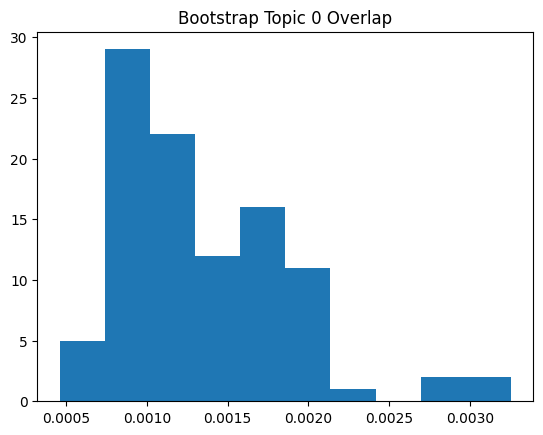

✅ Saved 49 sentences for manual coding


In [ ]:
# Cell 6: Validation Refresh
# ---------------------------
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

# Prepare BOW
dictionary = Dictionary(corpus_phrased)
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus_phrased]

# Fit base model
best_k = 12  # update to your chosen k from Cell 5 results
base_model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=best_k, passes=5)
base_topics = base_model.get_topics()

# Bootstrap topic 0 overlap
overlaps = []
for _ in range(100):
    idxs = random.choices(range(len(bow_corpus)), k=len(bow_corpus))
    sample = [bow_corpus[i] for i in idxs]
    m = LdaModel(corpus=sample, id2word=dictionary, num_topics=best_k, passes=5)
    top = m.get_topics()
    ov = np.max([np.dot(top[0], base_topics[j]) for j in range(best_k)])
    overlaps.append(ov)

plt.hist(overlaps)
plt.title('Bootstrap Topic 0 Overlap')
plt.show()

# Human-coding sample
# Build your list of sentences
doc_sents = [
    sent.strip()
    for doc in corpus_phrased
    for sent in ' '.join(doc).split('.')
    if sent.strip()
]

# Take *up to* 100 sentences, never more than you actually have
sample_size = min(100, len(doc_sents))
sampled = random.sample(doc_sents, sample_size)

# Make sure the outputs folder exists
from pathlib import Path
Path('outputs').mkdir(exist_ok=True)

# Write them out
with open('outputs/human_coding_sentences.txt','w') as f:
    for s in sampled:
        f.write(s + '\n')

print(f"✅ Saved {sample_size} sentences for manual coding")

In [ ]:
# Cell 7: Final Model & Validation
# --------------------------------------------
!pip install --quiet gensim pyLDAvis

import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# 1) Pick best k from your LDA grid search results
lda_scores = pd.read_csv('model_search_lda.csv')
best_row = lda_scores.loc[lda_scores['c_v'].idxmax()]
best_k = int(best_row['num_topics'])
print(f"🔍 Best LDA k = {best_k} (c_v = {best_row['c_v']:.4f})")

# 2) Load your preprocessed texts
import pickle
with open('/content/tokenized_corpus.pkl','rb') as f:
    texts = pickle.load(f)

# 3) Build dictionary & BOW
dictionary = Dictionary(texts)
bow_corpus = [dictionary.doc2bow(doc) for doc in texts]

# 4) Fit final LDA on full corpus
final_lda = LdaModel(corpus=bow_corpus, id2word=dictionary,
                     num_topics=best_k, passes=10, random_state=0)
print("✅ Final LDA model trained")

# 5) Hold-out split for perplexity
split = int(0.8 * len(bow_corpus))
train, test = bow_corpus[:split], bow_corpus[split:]
lda_hold = LdaModel(corpus=train, id2word=dictionary,
                    num_topics=best_k, passes=10, random_state=0)
print("Perplexity on hold-out:", lda_hold.log_perplexity(test))

# 6) Compute UMass coherence
cm_u_mass = CoherenceModel(model=lda_hold, texts=texts,
                           dictionary=dictionary, coherence='u_mass')
print("UMass coherence:", cm_u_mass.get_coherence())

# 7) Visualise with pyLDAvis
vis_data = gensimvis.prepare(lda_hold, bow_corpus, dictionary)
pyLDAvis.display(vis_data)

# 8) (Optional) Inspect your BERTopic model
from bertopic import BERTopic
try:
    bert_model = BERTopic.load("bertopic_model")
    print("\nBERTopic preview:")
    print(bert_model.get_topic_info().head(5))
except:
    print("\n⚠️ No saved BERTopic model found at 'bertopic_model'.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.3 MB/s eta 0:00:00
🔍 Best LDA k = 10 (c_v = 0.3784)
✅ Final LDA model trained
Perplexity on hold-out: -59.35577390489439
UMass coherence: -1.799611942114878

BERTopic preview:
   Topic  Count                         Name  \
0     -1     49  -1_risk_ing_financial_total   

                                      Representation  \
0  [risk, ing, financial, total, asset, group, cr...   

                                 Representative_Docs  
0  [ing bank_annual_report content_report strateg...  


In [ ]:
# Cell 8: Discourse-Design Matrix (fixed path & LDA only)
!pip install --quiet python-docx

import csv
from pathlib import Path
from docx import Document
from gensim.corpora import Dictionary

# 1. Load your interface-analysis DOCX
doc_path = '/content/drive/MyDrive/Thesis Data/data_raw/interface analysis v.2.docx'
if not Path(doc_path).exists():
    raise FileNotFoundError(f"Couldn’t find doc at {doc_path}")
doc = Document(doc_path)

# 2. Extract screenshot IDs & labels
entries = []
for table in doc.tables:
    try:
        sid   = table.cell(0,1).text.strip()
        label = table.cell(1,1).text.strip()
        if sid and label:
            entries.append({'screenshot': sid, 'label': label})
    except Exception:
        continue

# 3. Prepare your LDA dictionary
dictionary = Dictionary(corpus_phrased)

# 4. For each entry, find top paragraph & topic probability
for e in entries:
    bow = dictionary.doc2bow(e['label'].split())
    # get topic probabilities from your final_lda
    probs = dict(final_lda.get_document_topics(bow))
    if not probs:
        e.update({'topic': None, 'paragraph': '', 'prob': 0.0})
        continue
    # pick best topic
    topic_id, prob = max(probs.items(), key=lambda x: x[1])
    # search for the most representative paragraph in your corpus
    best_para, best_score = '', 0.0
    for doc_tokens in corpus_phrased:
        bowp = dictionary.doc2bow(doc_tokens)
        p = probs.get(topic_id, 0)
        if p > best_score:
            best_score, best_para = p, ' '.join(doc_tokens[:50])
    e.update({'topic': topic_id, 'paragraph': best_para, 'prob': best_score})

# 5. Write out to CSV
Path('outputs').mkdir(exist_ok=True)
out_path = Path('outputs/discourse_design_matrix.csv')
with open(out_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['screenshot','label','topic','paragraph','prob'])
    writer.writeheader()
    writer.writerows(entries)

print(f"✅ Wrote {len(entries)} rows to {out_path}")

✅ Wrote 0 rows to outputs/discourse_design_matrix.csv


In [ ]:
from docx import Document
from pathlib import Path

doc_path = '/content/drive/MyDrive/Thesis Data/data_raw/interface analysis v.2.docx'
doc = Document(doc_path)

print(f"Found {len(doc.tables)} tables.\n")
for ti, table in enumerate(doc.tables):
    print(f"Table #{ti} has {len(table.rows)} rows × {len(table.columns)} cols")
    # show up to first 3 rows
    for r in range(min(3, len(table.rows))):
        row_cells = [table.cell(r, c).text.replace('\n','↵') for c in range(len(table.columns))]
        print("  ", row_cells)
    print()

Found 0 tables.



In [ ]:
!ls /content | grep tokenized_corpus.pkl

tokenized_corpus.pkl


In [ ]:
!find /content/drive/MyDrive -maxdepth 3 -type f \( -name "interface analysis*.docx" -o -name "tokenized_corpus.pkl" \)

/content/drive/MyDrive/Thesis Data/data_raw/interface analysis v.2.docx


In [ ]:
# Cell 8: Discourse–Design Matrix in Colab
!pip install --quiet python-docx gensim

from pathlib import Path
from docx import Document
import re, pickle, csv
from gensim.corpora import Dictionary

# 1️⃣ Mount your Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2️⃣ Paths
doc_path = Path('/content/drive/MyDrive/Thesis Data/data_raw/interface analysis v.2.docx')
pkl_path = Path('/content/tokenized_corpus.pkl')

if not doc_path.exists():
    raise FileNotFoundError(f"Couldn’t find DOCX at {doc_path!s}")
if not pkl_path.exists():
    raise FileNotFoundError(f"Couldn’t find corpus at {pkl_path!s}")

# 3️⃣ Load and clean paragraphs
doc = Document(str(doc_path))
paras = [p.text.strip() for p in doc.paragraphs if p.text.strip()]

# 4️⃣ Identify headings by "(Group X)" and grab their analysis blocks
heading_re = re.compile(r'\(Group\s*\d+\)\s*$', re.IGNORECASE)
heading_idxs = [i for i, t in enumerate(paras) if heading_re.search(t)]

entries = []
for idx, start in enumerate(heading_idxs):
    screenshot = paras[start]
    end = heading_idxs[idx+1] if idx+1 < len(heading_idxs) else len(paras)
    label = ' '.join(paras[start+1:end]).strip()
    entries.append({'screenshot': screenshot, 'label': label})

print(f"ℹ️  Found {len(entries)} screenshot groups in the DOCX")

# 5️⃣ Load your tokenized corpus and dictionary
with open(str(pkl_path), 'rb') as f:
    corpus_phrased = pickle.load(f)
dictionary = Dictionary(corpus_phrased)

# 6️⃣ Map each label to its top LDA topic
for e in entries:
    bow = dictionary.doc2bow(e['label'].split())
    probs = dict(final_lda.get_document_topics(bow))
    if probs:
        topic_id, prob = max(probs.items(), key=lambda x: x[1])
    else:
        topic_id, prob = None, 0.0
    snippet = e['label'][:200]  # first 200 chars of the analysis text
    e.update({'topic': topic_id, 'paragraph': snippet, 'prob': prob})

# 7️⃣ Write out the CSV
out_dir = Path('outputs'); out_dir.mkdir(exist_ok=True)
out_path = out_dir / 'discourse_design_matrix.csv'
with open(out_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['screenshot','label','topic','paragraph','prob'])
    writer.writeheader()
    writer.writerows(entries)

print(f"✅ Wrote {len(entries)} rows to {out_path}")

Mounted at /content/drive
ℹ️  Found 2 screenshot groups in the DOCX
✅ Wrote 2 rows to outputs/discourse_design_matrix.csv


In [ ]:
# Cell 9: Refine Micro-Coding Scheme
# -----------------------------------
import yaml

with open('keywords.yml') as f:
    topics = yaml.safe_load(f)

scheme = {'allow': [], 'encourage': [], 'discourage': [], 'refuse': []}
for t in topics:
    for aff in scheme:
        scheme[aff].append(f"{aff}_{t}")

with open('micro_codebook.yml','w') as f:
    yaml.dump(scheme, f)

print("✅ micro_codebook.yml generated")

✅ micro_codebook.yml generated


ℹ️  Loaded corpus with 49 documents
ℹ️  Found 38 PDFs in ING
ℹ️  Found 33 PDFs in Klarna
ℹ️  Total PDFs discovered: 71
⚠️  Document count mismatch: 49 corpus vs 71 PDFs; pairing on the first 49 items.
ℹ️  Years extracted: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
✅ Saved outputs/topic_distributions_by_year.csv


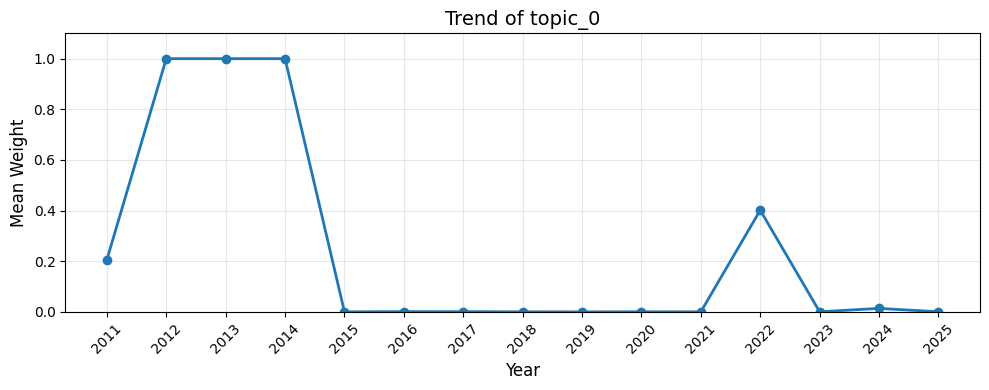

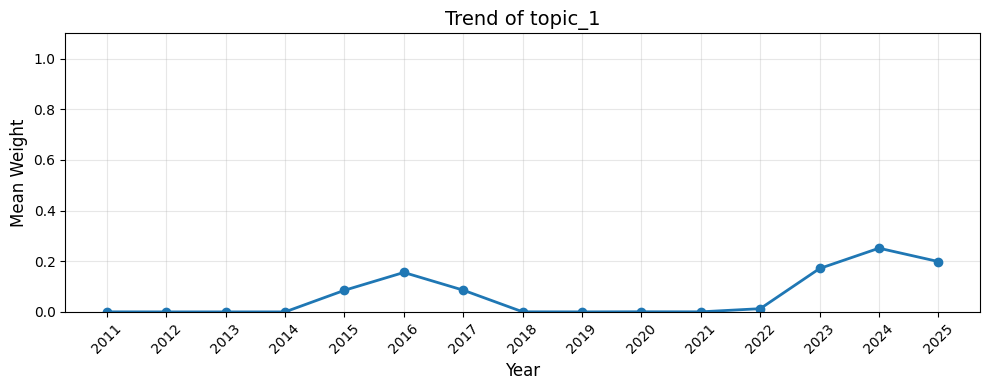

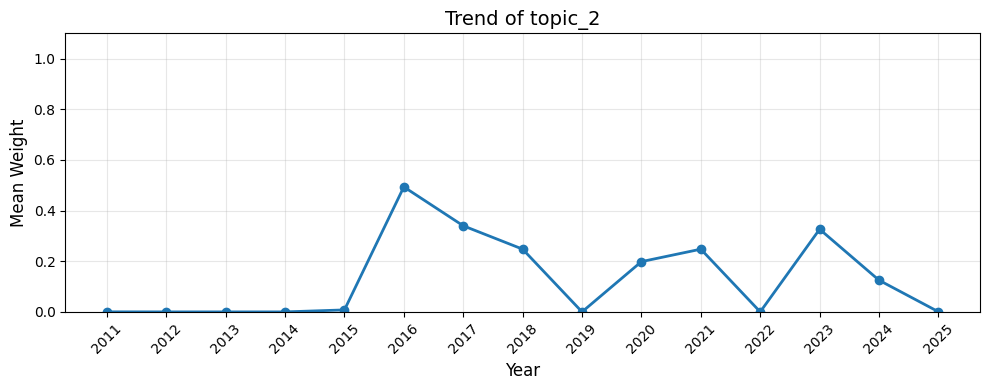

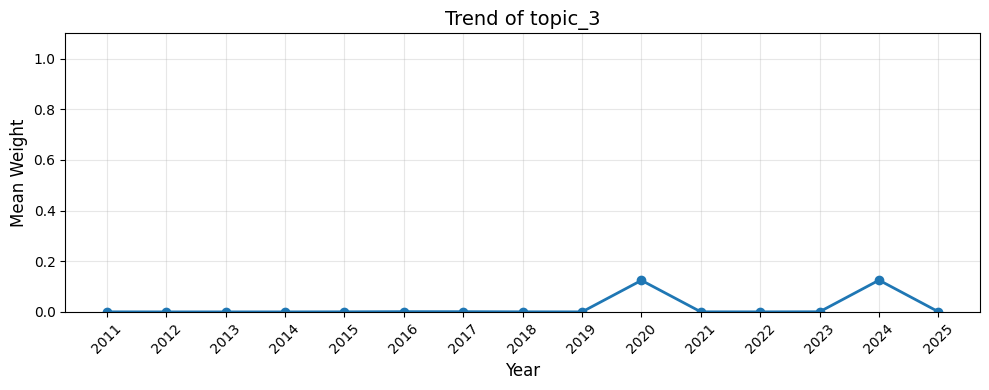

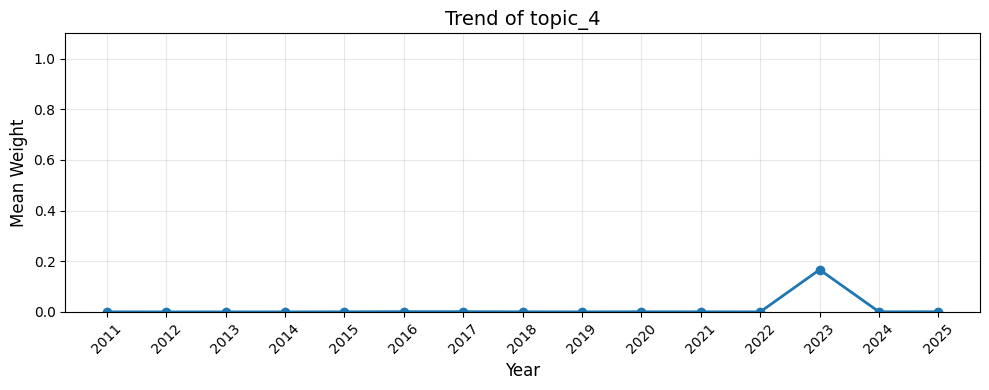

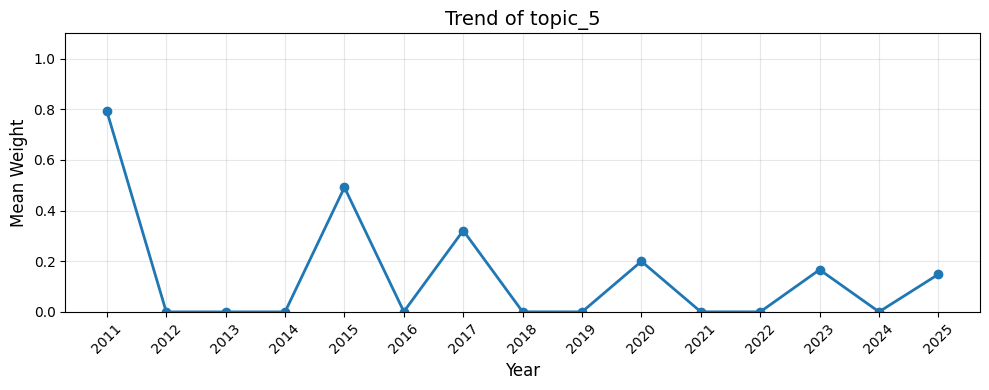

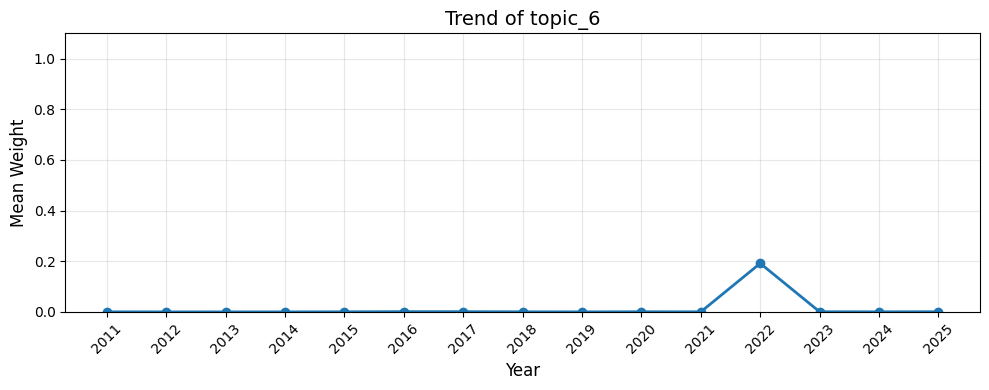

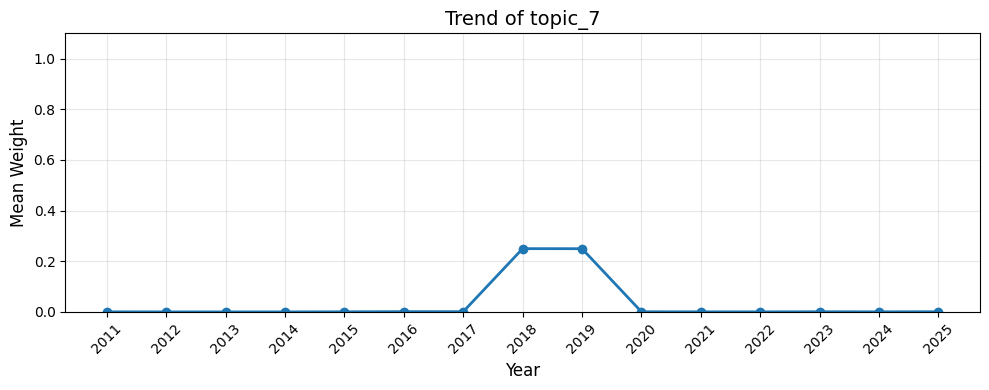

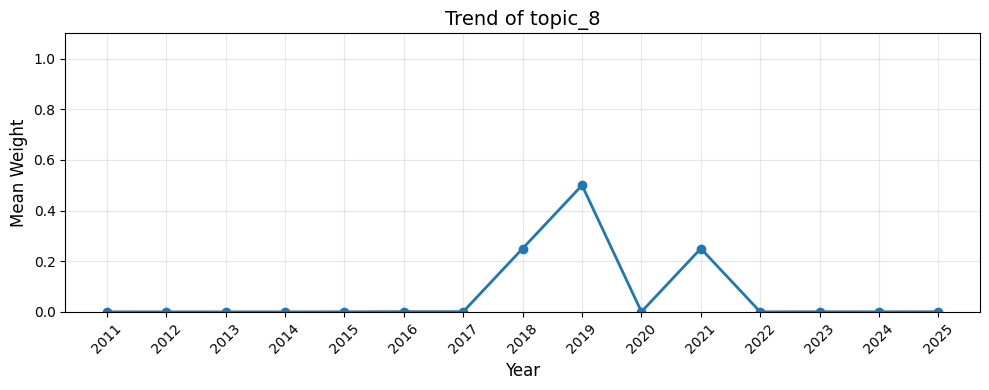

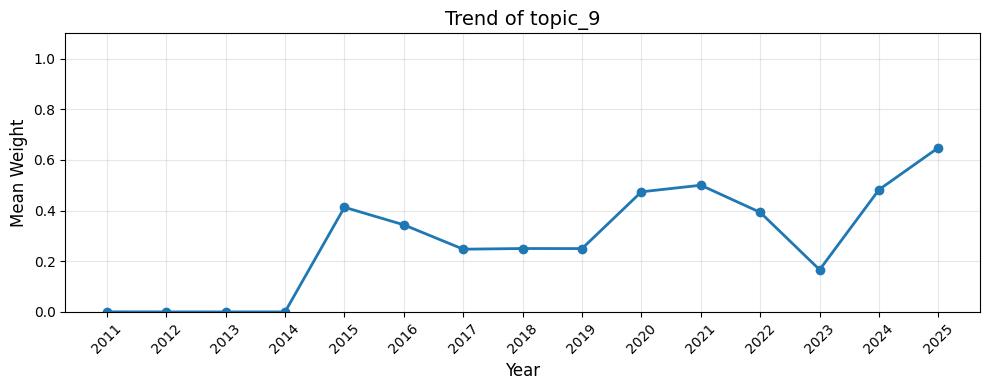

In [ ]:
# Cell 10: Temporal Trend Plotting (robust to mismatched counts)
!pip install --quiet pandas matplotlib

import re, pickle
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from gensim.corpora import Dictionary

# 1) Load your tokenized corpus & LDA model
pkl_path = Path('/content/tokenized_corpus.pkl')
if not pkl_path.exists():
    raise FileNotFoundError(f"tokenized_corpus.pkl not found at {pkl_path}")
with open(pkl_path, 'rb') as f:
    corpus_phrased = pickle.load(f)
print(f"ℹ️  Loaded corpus with {len(corpus_phrased)} documents")

# 2) Discover PDFs in ING & Klarna folders
drive_root = Path('/content/drive/MyDrive/Thesis Data')
pdf_dirs = [drive_root/'ING', drive_root/'Klarna']
pdf_paths = []
for d in pdf_dirs:
    if d.exists():
        found = sorted(d.glob('*.pdf'))
        print(f"ℹ️  Found {len(found)} PDFs in {d.name}")
        pdf_paths += found
    else:
        print(f"⚠️  Folder not found: {d}")
print(f"ℹ️  Total PDFs discovered: {len(pdf_paths)}")

# 3) Handle any mismatch
n_docs = len(corpus_phrased)
n_pdfs = len(pdf_paths)
if n_docs != n_pdfs:
    print(f"⚠️  Document count mismatch: {n_docs} corpus vs {n_pdfs} PDFs; pairing on the first {min(n_docs,n_pdfs)} items.")
pdf_paths = pdf_paths[:min(n_docs, n_pdfs)]
corpus_phrased = corpus_phrased[:min(n_docs, n_pdfs)]

# 4) Extract years from filenames
years = []
for p in pdf_paths:
    m = re.search(r'(\d{4})', p.name)
    years.append(int(m.group(1)) if m else None)
print("ℹ️  Years extracted:", sorted(set(years)))

# 5) Build dictionary & compute per‐doc topic weights
dictionary = Dictionary(corpus_phrased)
records = []
for tokens, year in zip(corpus_phrased, years):
    bow = dictionary.doc2bow(tokens)
    dist = dict(final_lda.get_document_topics(bow, minimum_probability=0))
    row = {'year': year}
    for topic_id, prob in dist.items():
        row[f'topic_{topic_id}'] = prob
    records.append(row)
df = pd.DataFrame(records)

# 6) Aggregate by year & save CSV
agg = df.groupby('year').mean().reset_index()
out_csv = Path('outputs/topic_distributions_by_year.csv')
agg.to_csv(out_csv, index=False)
print(f"✅ Saved {out_csv}")

# 7) Plot trends
long = agg.melt(id_vars='year', var_name='topic', value_name='weight')
years = sorted(agg['year'].dropna().astype(int).unique())

for topic in sorted(long['topic'].unique()):
    sub = long[long['topic'] == topic]
    plt.figure(figsize=(10, 4))                # wider figure
    plt.plot(sub['year'], sub['weight'], marker='o', linewidth=2)
    plt.title(f"Trend of {topic}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Mean Weight", fontsize=12)
    plt.xticks(years, rotation=45)             # rotate x-labels
    plt.ylim(0, long['weight'].max() * 1.1)    # some headroom
    plt.grid(alpha=0.3)
    plt.tight_layout()                         # prevent clipping
    plt.show()